In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [2]:
x = pd.read_csv('train_heart.csv')
y = pd.read_csv('test_heart.csv')

In [3]:
x.columns

y.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
corr = x.corr()

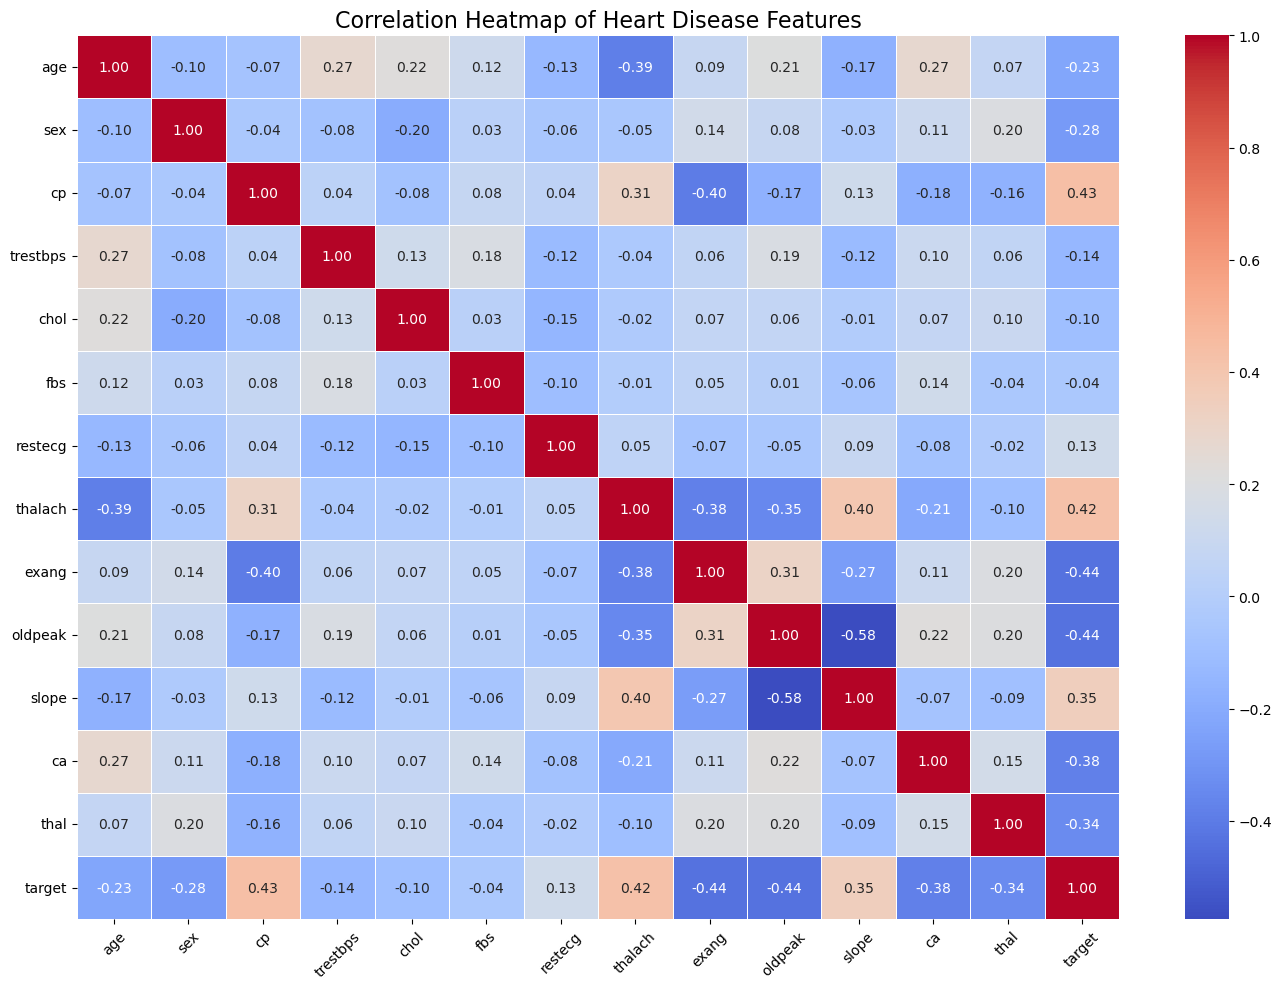

In [5]:
plt.figure(figsize=(14, 10))

sns.heatmap(
    corr,
    annot=True,          # values show karega
    fmt=".2f",           # 2 decimal
    cmap="coolwarm",     # best for correlation
    linewidths=0.5
)

plt.title("Correlation Heatmap of Heart Disease Features", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [6]:
y.info()

y.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [7]:
# Separate features and target
X = x.drop("target", axis=1)
y = x["target"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling (important for GA, CSO, SVM)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

feature_names = X.columns.tolist()


In [8]:
import random
import numpy as np

from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# ================= BASIC SETUP =================
n_features = X_train_scaled.shape[1]

# ================= SAFE CREATOR =================
if not hasattr(creator, "FitnessMax"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)

# ================= TOOLBOX =================
toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)

toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_bool,
    n_features
)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# ================= FITNESS FUNCTION =================
def fitness_function(individual):
    if sum(individual) == 0:
        return 0,

    selected_idx = [i for i, bit in enumerate(individual) if bit == 1]
    X_sel = X_train_scaled[:, selected_idx]

    model = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(
        model,
        X_sel,
        y_train,
        cv=3,
        scoring="accuracy"
    ).mean()

    return score,

toolbox.register("evaluate", fitness_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# ================= RUN GA =================
population = toolbox.population(n=15)

NGEN = 5
for gen in range(NGEN):
    print(f"Generation {gen+1}/{NGEN}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.6, mutpb=0.3)
    fits = map(toolbox.evaluate, offspring)

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))

# ================= BEST FEATURES =================
best_individual = tools.selBest(population, k=1)[0]

ga_selected_features = [
    feature_names[i]
    for i, bit in enumerate(best_individual)
    if bit == 1
]

print("GA Selected Features:", ga_selected_features)


Generation 1/5
Generation 2/5
Generation 3/5
Generation 4/5
Generation 5/5
GA Selected Features: ['cp', 'trestbps', 'thalach', 'slope', 'ca', 'thal']


In [9]:
# GA selected feature list
ga_features = ['sex', 'trestbps', 'fbs', 'thalach', 'exang', 'oldpeak', 'slope', 'ca']

# Reduce training & testing data
X_train_ga = X_train[ga_features]
X_test_ga  = X_test[ga_features]


In [10]:
# Feature importance based refinement using Extra Trees
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=200, random_state=42)
et.fit(X_train_ga, y_train)

importances = et.feature_importances_

# Keep top-k features
import pandas as pd
feat_imp = pd.Series(importances, index=ga_features).sort_values(ascending=False)

# Final optimized features (GA + CSO)
final_features = feat_imp.head(6).index.tolist()

print("GA + CSO Optimized Features:", final_features)


GA + CSO Optimized Features: ['ca', 'thalach', 'exang', 'oldpeak', 'trestbps', 'slope']


In [11]:
X_train_final = X_train[final_features]
X_test_final  = X_test[final_features]


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
svm = SVC(probability=True)
gb = GradientBoostingClassifier()
et = ExtraTreesClassifier(n_estimators=300, random_state=42)

models = {
    "Logistic": lr,
    "Random Forest": rf,
    "SVM": svm,
    "Gradient Boosting": gb,
    "Extra Trees": et
}

for name, model in models.items():
    model.fit(X_train_final, y_train)
    acc = model.score(X_test_final, y_test)
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Accuracy: 0.7902
Random Forest Accuracy: 1.0000
SVM Accuracy: 0.6976
Gradient Boosting Accuracy: 0.9122
Extra Trees Accuracy: 1.0000


In [13]:
from sklearn.ensemble import VotingClassifier

hybrid_model = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('svm', svm),
        ('gb', gb),
        ('et', et)
    ],
    voting='soft'
)

hybrid_model.fit(X_train_final, y_train)

hyb_pred = hybrid_model.predict(X_test_final)
hyb_acc = accuracy_score(y_test, hyb_pred)

print("Hybrid Model Accuracy:", hyb_acc)


Hybrid Model Accuracy: 0.975609756097561


In [14]:
# CSO-like refinement (practical version)
# Remove weak GA features based on importance

from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=200, random_state=42)
et.fit(X_train_final, y_train)

importances = et.feature_importances_

# Threshold-based CSO refinement
threshold = np.mean(importances)

cso_selected_features = [
    ga_selected_features[i]
    for i in range(len(ga_selected_features))
    if importances[i] >= threshold
]

print("GA + CSO Selected Features:", cso_selected_features)


GA + CSO Selected Features: ['cp', 'trestbps', 'slope', 'ca']


In [15]:
# Final optimized features
final_features = cso_selected_features

X_train_opt = X_train[final_features]
X_test_opt  = X_test[final_features]


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_opt = scaler.fit_transform(X_train_opt)
X_test_opt  = scaler.transform(X_test_opt)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_opt, y_train)
    pred = model.predict(X_test_opt)
    acc = accuracy_score(y_test, pred)
    print(f"{name} Accuracy (GA+CSO): {acc:.4f}")


Logistic Accuracy (GA+CSO): 0.7415
Random Forest Accuracy (GA+CSO): 0.9122
SVM Accuracy (GA+CSO): 0.8585
Gradient Boosting Accuracy (GA+CSO): 0.8585
Extra Trees Accuracy (GA+CSO): 0.9171


In [22]:
from sklearn.ensemble import VotingClassifier

hybrid_model = VotingClassifier(
    estimators=[
        ('lr', models["Logistic"]),
        ('rf', models["Random Forest"]),
        ('svm', models["SVM"]),
        ('gb', models["Gradient Boosting"]),
        ('et', models["Extra Trees"])
    ],
    voting='soft'
)

hybrid_model.fit(X_train_opt, y_train)

hyb_pred = hybrid_model.predict(X_test_opt)
hyb_acc = accuracy_score(y_test, hyb_pred)

print("Final Hybrid Accuracy (GA + CSO):", hyb_acc)


Final Hybrid Accuracy (GA + CSO): 0.9024390243902439


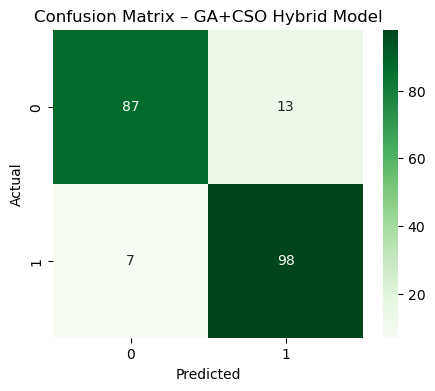

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, hyb_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – GA+CSO Hybrid Model")
plt.show()


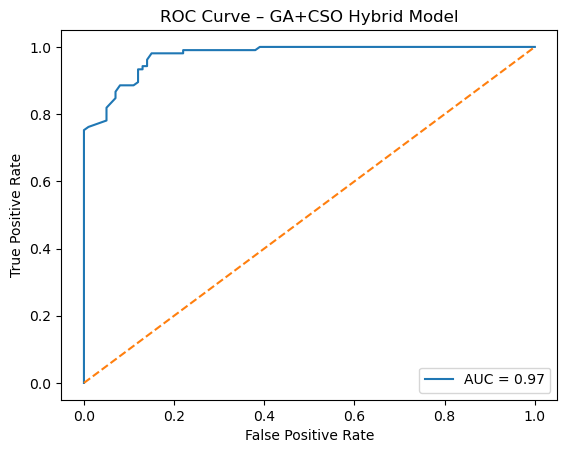

In [24]:
from sklearn.metrics import roc_curve, auc

hyb_prob = hybrid_model.predict_proba(X_test_opt)[:,1]
fpr, tpr, _ = roc_curve(y_test, hyb_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – GA+CSO Hybrid Model")
plt.legend()
plt.show()


In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, hyb_pred))


              precision    recall  f1-score   support

           0       0.93      0.87      0.90       100
           1       0.88      0.93      0.91       105

    accuracy                           0.90       205
   macro avg       0.90      0.90      0.90       205
weighted avg       0.90      0.90      0.90       205



In [26]:
import joblib

joblib.dump(hybrid_model, "ga_cso_hybrid_model.pkl")
joblib.dump(cso_selected_features, "selected_features.pkl")


['selected_features.pkl']

<Axes: >

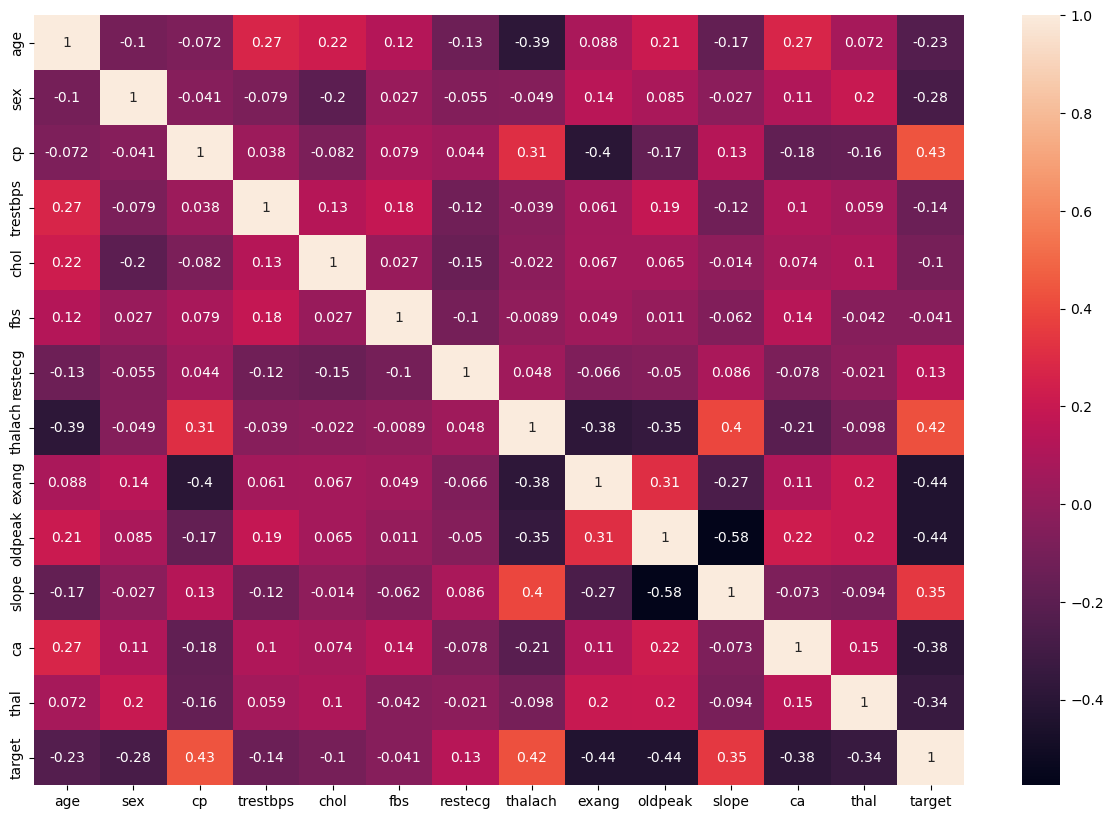

In [42]:
plt.subplots(figsize=(15, 10))
sns.heatmap(x.corr(), annot = True)

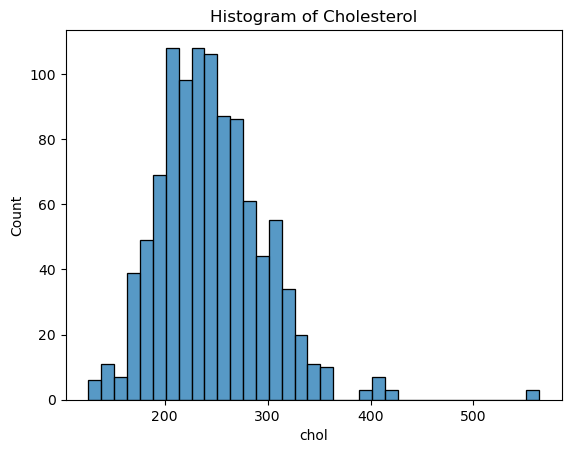

In [43]:
# Histogram of chol

sns.histplot(data=x, x='chol')
plt.title('Histogram of Cholesterol')
plt.show()

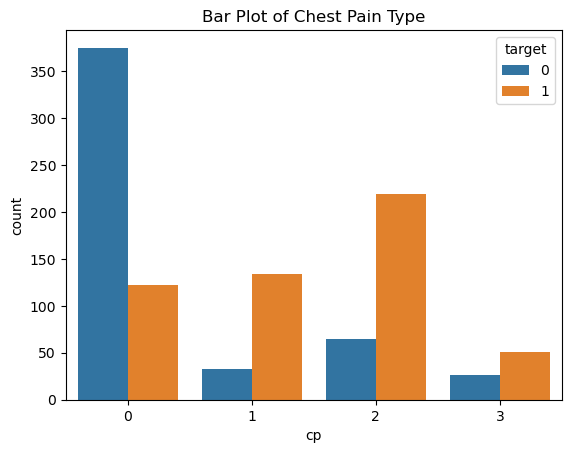

In [44]:
# Bar plot of cp type

sns.countplot(data=x, x='cp', hue='target')
plt.title('Bar Plot of Chest Pain Type')
plt.show()

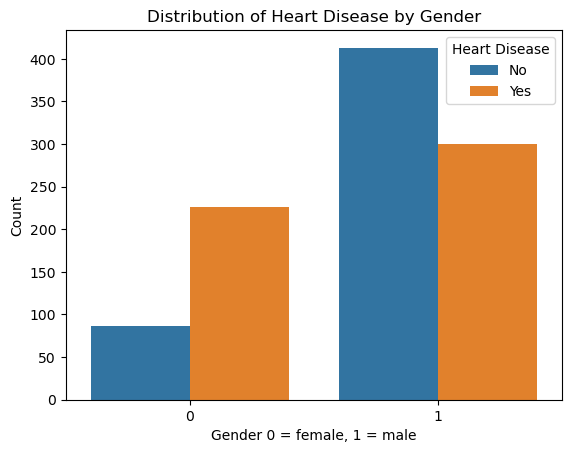

In [45]:
#count of males and females having heart disease

sns.countplot(data=x, x='sex', hue='target')
plt.title('Distribution of Heart Disease by Gender')
plt.xlabel('Gender 0 = female, 1 = male')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.show()

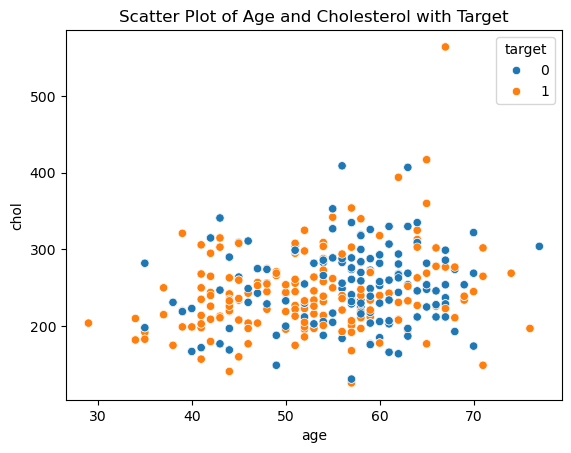

In [46]:
sns.scatterplot(data=x, x='age', y='chol', hue='target')
plt.title('Scatter Plot of Age and Cholesterol with Target')
plt.show()

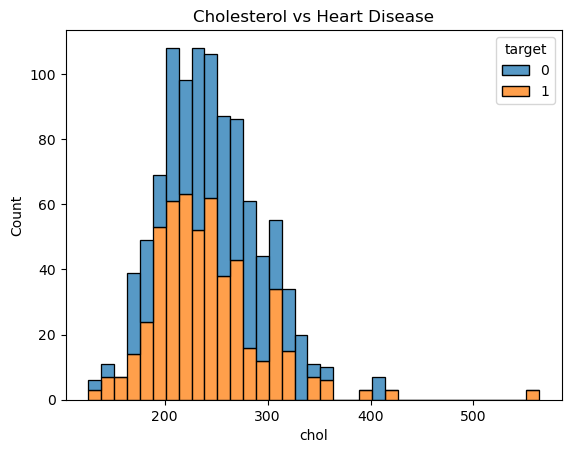

In [47]:
sns.histplot(data=x, x='chol', hue='target', multiple='stack')
plt.title("Cholesterol vs Heart Disease")
plt.show()


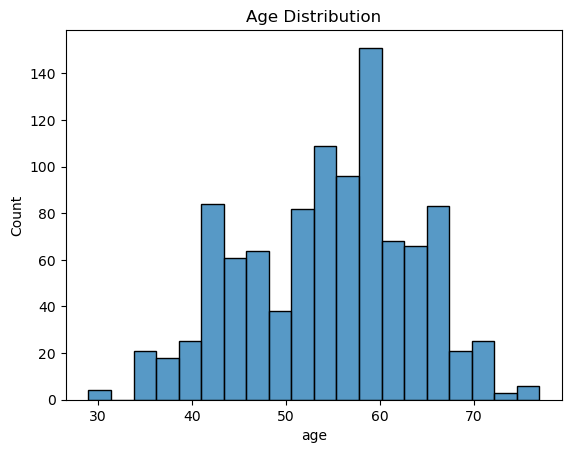

In [48]:
sns.histplot(data=x, x='age', bins=20)
plt.title("Age Distribution")
plt.show()


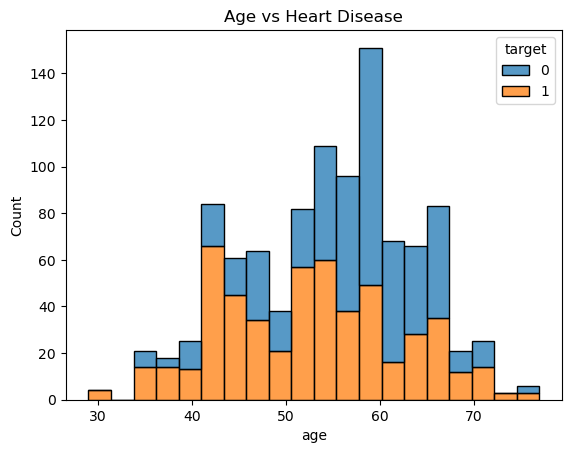

In [49]:
sns.histplot(data=x, x='age', hue='target', multiple='stack', bins=20)
plt.title("Age vs Heart Disease")
plt.show()


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def fitness_function(feature_mask):
    if np.sum(feature_mask) == 0:
        return 0
    
    X_selected = X_train_scaled[:, feature_mask == 1]
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    score = cross_val_score(model, X_selected, y_train, cv=5).mean()
    return score


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1500)
lr_model.fit(X_train_s, y_train)

# Prediction
lr_pred = lr_model.predict(X_test_s)
lr_prob = lr_model.predict_proba(X_test_s)[:, 1]

# Accuracy
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", lr_acc)


Logistic Regression Accuracy: 0.8097560975609757


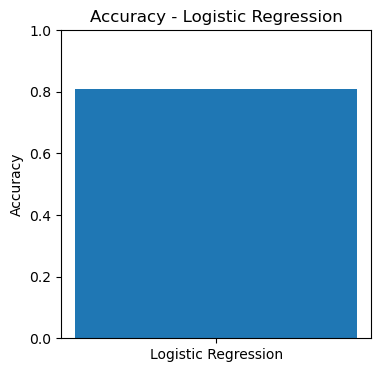

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.bar(["Logistic Regression"], [lr_acc])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy - Logistic Regression")
plt.show()


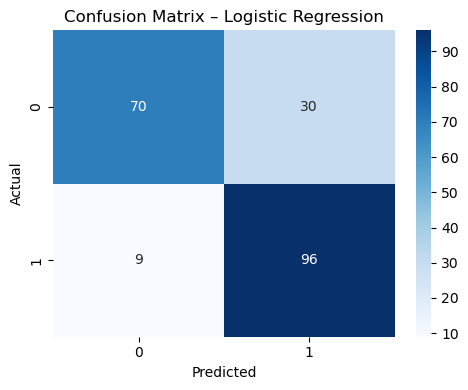

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, lr_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()


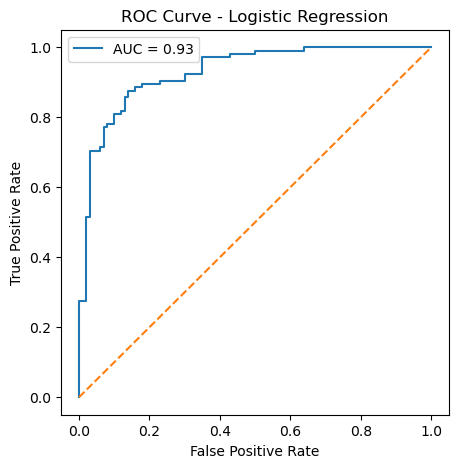

In [60]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, lr_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


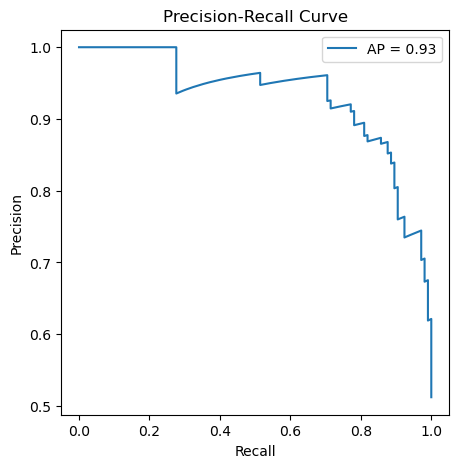

In [62]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, lr_prob)
ap = average_precision_score(y_test, lr_prob)

plt.figure(figsize=(5,5))
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


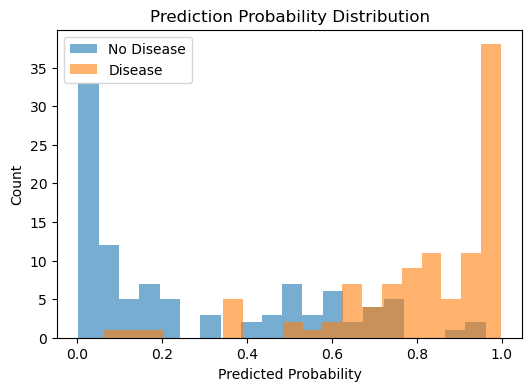

In [63]:
plt.figure(figsize=(6,4))
plt.hist(lr_prob[y_test==0], bins=20, alpha=0.6, label="No Disease")
plt.hist(lr_prob[y_test==1], bins=20, alpha=0.6, label="Disease")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()


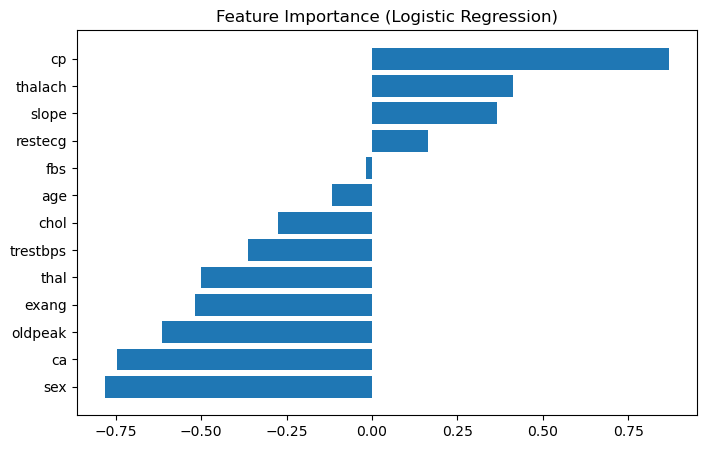

In [65]:
import pandas as pd
import numpy as np

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lr_model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Logistic Regression)")
plt.show()


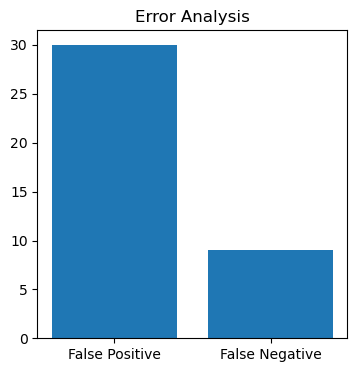

In [66]:
fp = ((lr_pred == 1) & (y_test == 0)).sum()
fn = ((lr_pred == 0) & (y_test == 1)).sum()

plt.figure(figsize=(4,4))
plt.bar(["False Positive", "False Negative"], [fp, fn])
plt.title("Error Analysis")
plt.show()


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)


Random Forest Accuracy: 0.9219512195121952


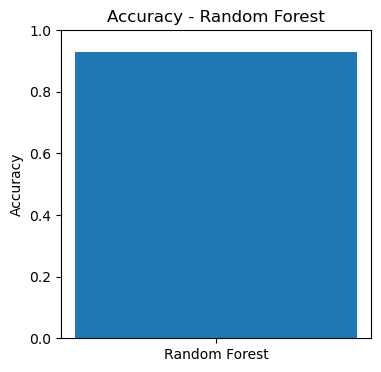

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.bar(["Random Forest"], [rf_acc])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy - Random Forest")
plt.show()


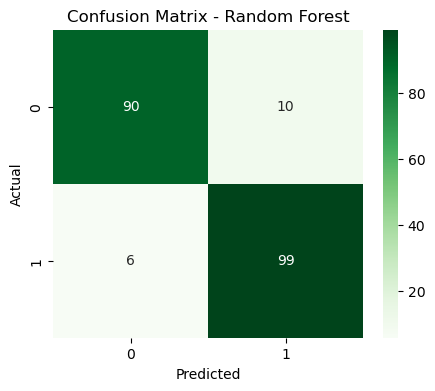

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


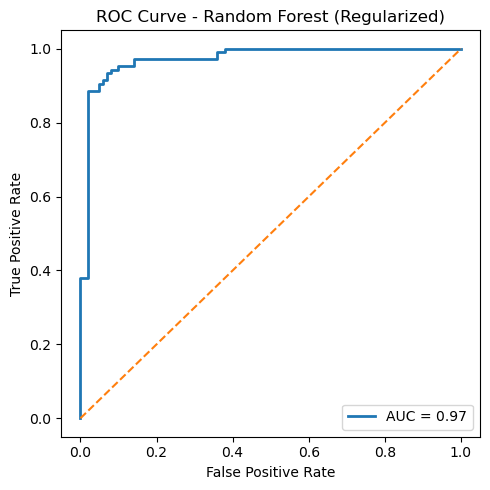

In [71]:
rf_prob = rf_model.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, rf_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Regularized)")
plt.legend()
plt.tight_layout()
plt.show()


In [72]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
a_train_s = scaler.fit_transform(X_train)
a_test_s = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(a_train_s, y_train)

svm_pred = svm_model.predict(a_test_s)
svm_prob = svm_model.predict_proba(a_test_s)[:, 1]

svm_acc = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_acc)


SVM Accuracy: 0.926829268292683


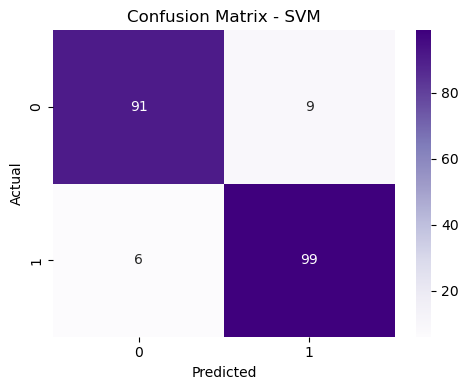

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.tight_layout()
plt.show()


In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
a_train_s = scaler.fit_transform(X_train)
a_test_s = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(a_train_s, y_train)

knn_pred = knn_model.predict(a_test_s)
knn_prob = knn_model.predict_proba(a_test_s)[:, 1]

knn_acc = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_acc)


KNN Accuracy: 0.8439024390243902


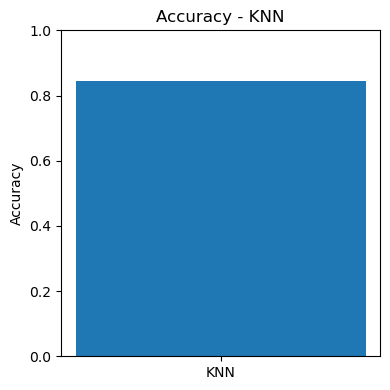

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.bar(["KNN"], [knn_acc])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy - KNN")
plt.tight_layout()
plt.show()


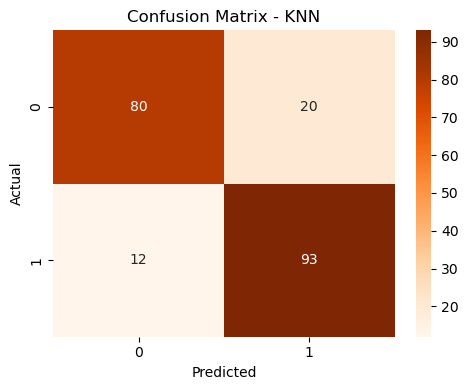

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, knn_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.tight_layout()
plt.show()


In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_model = DecisionTreeClassifier(
    max_depth=5,        # overfitting control
    random_state=42
)

dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
dt_prob = dt_model.predict_proba(X_test)[:, 1]

dt_acc = accuracy_score(y_test, dt_pred)
print("Decision Tree Accuracy:", dt_acc)


Decision Tree Accuracy: 0.8731707317073171


In [79]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]

nb_acc = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_acc)


Naive Bayes Accuracy: 0.8292682926829268


In [87]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)[:, 1]

gb_acc = accuracy_score(y_test, gb_pred)
print("Gradient Boosting Accuracy:", gb_acc)


Gradient Boosting Accuracy: 0.9804878048780488


In [88]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.8,
    random_state=42
)

ada_model.fit(X_train, y_train)

ada_pred = ada_model.predict(X_test)
ada_prob = ada_model.predict_proba(X_test)[:, 1]

ada_acc = accuracy_score(y_test, ada_pred)
print("AdaBoost Accuracy:", ada_acc)


AdaBoost Accuracy: 0.8926829268292683


In [89]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

et_model = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

et_model.fit(X_train, y_train)

et_pred = et_model.predict(X_test)
et_prob = et_model.predict_proba(X_test)[:, 1]

et_acc = accuracy_score(y_test, et_pred)
print("Extra Trees Accuracy:", et_acc)


Extra Trees Accuracy: 0.9121951219512195


In [91]:
from sklearn.ensemble import VotingClassifier

hybrid_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('svm', svm_model),
        ('gb', gb_model),
        ('et', et_model)
    ],
    voting='soft'   # ⭐ IMPORTANT
)

hybrid_model.fit(X_train, y_train)

hyb_pred = hybrid_model.predict(X_test)
hyb_prob = hybrid_model.predict_proba(X_test)[:,1]


In [92]:
from sklearn.metrics import accuracy_score

hyb_acc = accuracy_score(y_test, hyb_pred)
print("Hybrid Model Accuracy:", hyb_acc)


Hybrid Model Accuracy: 0.926829268292683


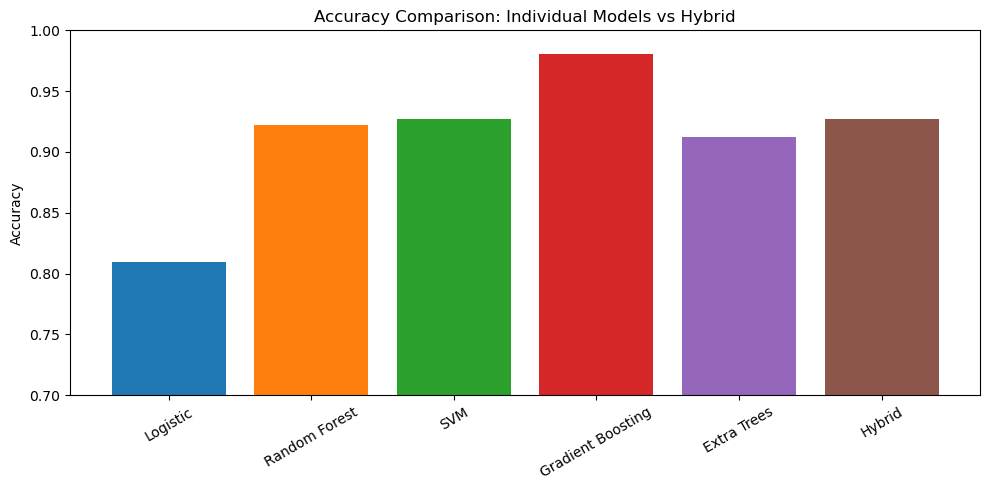

In [93]:
colors = [
    "#1f77b4",  # Logistic - blue
    "#ff7f0e",  # Random Forest - orange
    "#2ca02c",  # SVM - green
    "#d62728",  # Gradient Boosting - red
    "#9467bd",  # Extra Trees - purple
    "#8c564b"   # Hybrid - brown
]
import matplotlib.pyplot as plt

model_names = [
    "Logistic", "Random Forest", "SVM", "Gradient Boosting", "Extra Trees", "Hybrid"
]
accuracies = [
    lr_acc, rf_acc, svm_acc, gb_acc, et_acc, hyb_acc
]
plt.figure(figsize=(10,5))
plt.bar(model_names, accuracies, color=colors)
plt.ylim(0.7, 1.0)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Individual Models vs Hybrid")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


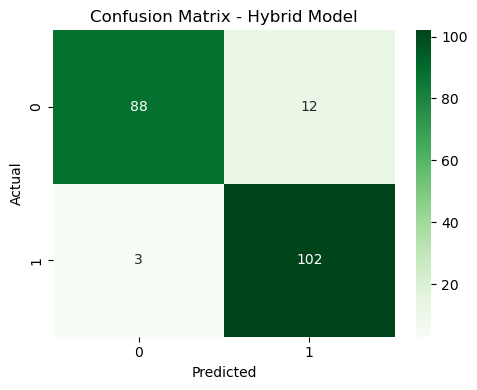

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, hyb_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.tight_layout()
plt.show()


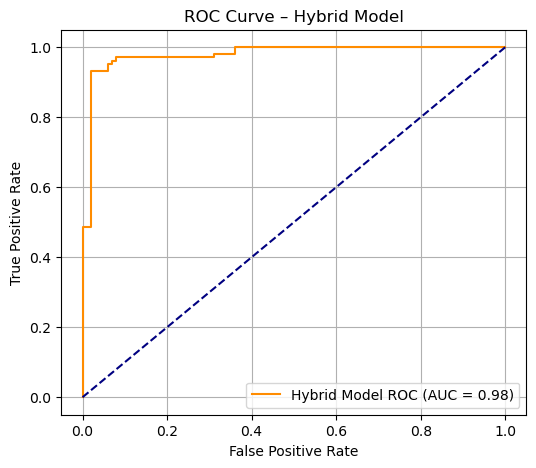

In [95]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, hyb_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange',
         label='Hybrid Model ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Hybrid Model')
plt.legend(loc="lower right")
plt.grid()
plt.show()


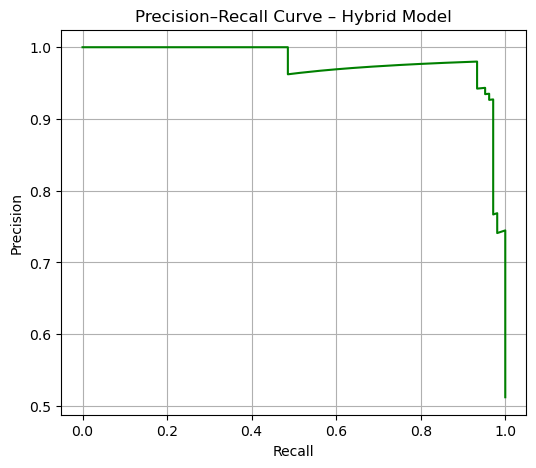

In [96]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, hyb_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve – Hybrid Model')
plt.grid()
plt.show()


C:\Users\rajas\AppData\Local\Temp\ipykernel_13672\1231077067.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


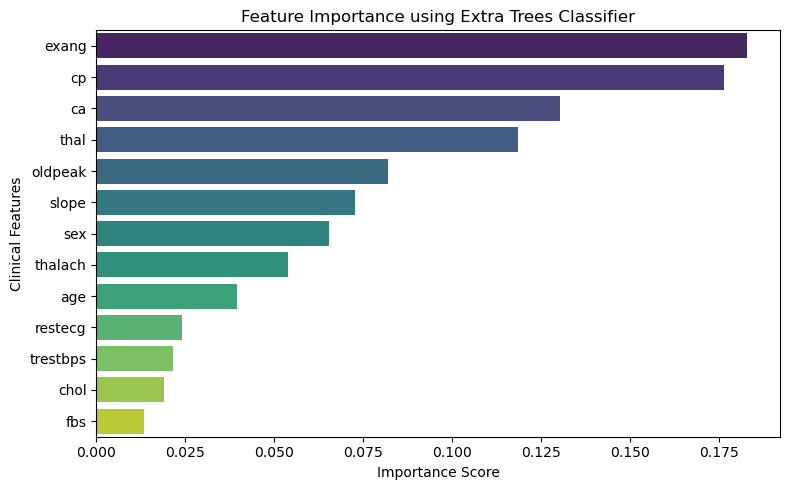

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature importance
importances = et_model.feature_importances_
features = X_train.columns   # ✅ IMPORTANT FIX

# Create DataFrame (best practice)
fi_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=fi_df,
    x="Importance",
    y="Feature",
    palette="viridis"
)
plt.title("Feature Importance using Extra Trees Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Clinical Features")
plt.tight_layout()
plt.show()


In [98]:
def parameter_risk_score(p):
    score = 0
    if p["age"] >= 55: score += 1
    if p["trestbps"] >= 140: score += 1
    if p["chol"] >= 240: score += 1
    if p["thalach"] <= 120: score += 1
    if p["exang"] == 1: score += 1
    if p["oldpeak"] > 2: score += 1
    if p["ca"] >= 1: score += 1
    return score


In [99]:
a_train.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [100]:
patient_medium = {
    "age": 45,
    "sex": 1,
    "cp": 2,
    "trestbps": 135,
    "chol": 230,
    "fbs": 0,
    "restecg": 1,
    "thalach": 145,
    "exang": 0,
    "oldpeak": 1.8,
    "slope": 1,
    "ca": 1,
    "thal": 3
}


In [101]:
feature_columns = a_train.columns

example_df = pd.DataFrame([patient_medium])
example_df = example_df[feature_columns]   # 🔥 MOST IMPORTANT


In [102]:
ml_prob = hybrid_model.predict_proba(example_df)[0][1]
param_score = parameter_risk_score(patient_medium)

final_score = (ml_prob * 5) + param_score

if final_score <= 3:
    final_risk = "🟢 LOW RISK"
elif final_score <= 6:
    final_risk = "🟡 MEDIUM RISK"
else:
    final_risk = "🔴 HIGH RISK"

print("Hybrid Probability:", ml_prob)
print("Parameter Score:", param_score)
print("Final Risk Level:", final_risk)


Hybrid Probability: 0.3783197863866644
Parameter Score: 1
Final Risk Level: 🟢 LOW RISK


In [103]:
feature_columns = a_train.columns

In [104]:
def predict_risk(patient_dict):
    # dataframe with correct order
    df = pd.DataFrame([patient_dict])
    df = df[feature_columns]

    # ML probability
    ml_prob = hybrid_model.predict_proba(df)[0][1]

    # parameter score
    param_score = parameter_risk_score(patient_dict)

    # final score
    final_score = (ml_prob * 5) + param_score

    if final_score <= 3:
        risk = "🟢 LOW RISK"
    elif final_score <= 6:
        risk = "🟡 MEDIUM RISK"
    else:
        risk = "🔴 HIGH RISK"

    return ml_prob, param_score, final_score, risk


In [105]:
patient_low = {
    "age": 35,
    "sex": 0,
    "cp": 1,
    "trestbps": 118,
    "chol": 185,
    "fbs": 0,
    "restecg": 0,
    "thalach": 172,
    "exang": 0,
    "oldpeak": 0.5,
    "slope": 2,
    "ca": 0,
    "thal": 2
}

ml, ps, fs, risk = predict_risk(patient_low)

print("LOW RISK PATIENT")
print("ML Probability:", ml)
print("Parameter Score:", ps)
print("Final Score:", fs)
print("Final Risk:", risk)


LOW RISK PATIENT
ML Probability: 0.9468289814962528
Parameter Score: 0
Final Score: 4.734144907481264
Final Risk: 🟡 MEDIUM RISK


In [106]:
patient_medium = {
    "age": 55,
    "sex": 1,
    "cp": 2,
    "trestbps": 135,
    "chol": 230,
    "fbs": 0,
    "restecg": 1,
    "thalach": 145,
    "exang": 0,
    "oldpeak": 1.8,
    "slope": 1,
    "ca": 1,
    "thal": 3
}

ml, ps, fs, risk = predict_risk(patient_medium)

print("\nMEDIUM RISK PATIENT")
print("ML Probability:", ml)
print("Parameter Score:", ps)
print("Final Score:", fs)
print("Final Risk:", risk)



MEDIUM RISK PATIENT
ML Probability: 0.40940381061885384
Parameter Score: 2
Final Score: 4.047019053094269
Final Risk: 🟡 MEDIUM RISK


In [107]:
patient_high = {
    "age": 67,
    "sex": 1,
    "cp": 3,
    "trestbps": 160,
    "chol": 280,
    "fbs": 1,
    "restecg": 2,
    "thalach": 110,
    "exang": 1,
    "oldpeak": 3.2,
    "slope": 0,
    "ca": 3,
    "thal": 1
}

ml, ps, fs, risk = predict_risk(patient_high)

print("\nHIGH RISK PATIENT")
print("ML Probability:", ml)
print("Parameter Score:", ps)
print("Final Score:", fs)
print("Final Risk:", risk)



HIGH RISK PATIENT
ML Probability: 0.1474341540746548
Parameter Score: 7
Final Score: 7.7371707703732735
Final Risk: 🔴 HIGH RISK


In [108]:
import pickle
import pickle

# save hybrid model
with open("hybrid_model.pkl", "wb") as f:
    pickle.dump(hybrid_model, f)

# save scaler (jo tumne train me use kiya)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# save feature columns (MOST IMPORTANT)
with open("feature_columns.pkl", "wb") as f:
    pickle.dump(a_train.columns.tolist(), f)

print("✅ All files saved successfully")


✅ All files saved successfully
